In [ ]:
# Project_glass
!git clone https://github.com/Mike030668/Project_glass.git -q
# Genetic_generation_net
!git clone https://github.com/Mike030668/Genetic_generation_net.git -q
# установка библиотека контроля  времени
!pip install stopit -q


  Preparing metadata (setup.py) ... done


# imports

In [ ]:
import sys
dir_glass = '/content/Project_glass'
dir_gen = '/content/Genetic_generation_net'
sys.path.append(dir_gen)
sys.path.append(dir_glass)


# Project_glass
from prepare_data.const_predprice import MAKE_LOG_TARGET
from prepare_data.constants import BATCH_SIZE, DEPTH, PREDICT_LAG

# Genetic_generation_net
from genetic.process_with_generator import selection

import numpy as np # библиотека нампи
import matplotlib.pyplot as plt # библиотека матплотлиб для отрисовки
from IPython.display import clear_output # очистка вывода в ячейке
import joblib
#import pandas as pd    # библиотека пандас
import tensorflow as tf # библиотека машинного обучения

# load prepared train data

data prepared with vcs note makedata_vsc.ipynb

In [ ]:
x_train_sc = np.load(dir_glass + "/predprice/x_train_sc.npy")
x_val_sc = np.load(dir_glass + "/predprice/x_val_sc.npy")
y_train_sc = np.load(dir_glass +  "/predprice/y_train_sc.npy")
y_val_sc = np.load(dir_glass + "/predprice/y_val_sc.npy")
Y_SCAILER = joblib.load(dir_glass + "/predprice/y_scailer.save")

In [ ]:
# Для генерации выборки временных рядов
TSG = tf.keras.preprocessing.sequence.TimeseriesGenerator

# Создаем генератор для обучения
train_datagen = TSG(x_train_sc, y_train_sc,          # В качестве параметров наши выборки
                    length = DEPTH,            # Анализируем по 21 прошедшим точкам
                    sampling_rate = 1,         # Для каждой точки
                    batch_size = BATCH_SIZE)   # Размер batch, который будем скармливать модели

# Создаем аналогичный генератор для валидации при обучении
val_datagen = TSG(x_val_sc, y_val_sc,                # В качестве параметров наши выборки
                    length = DEPTH,            # Анализируем по 21 прошедшим точкам
                    sampling_rate = 1,         # Для каждой точки
                    batch_size = BATCH_SIZE)   # Размер batch, который будем скармливать модели

print(train_datagen[0][0].shape,
      val_datagen[0][1].shape)

# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки/оценки
DataGen = TSG(x_val_sc, y_val_sc,              # В качестве параметров наши выборки
              length = DEPTH,            # Анализируем по 21 прошедшим точкам
              sampling_rate = 1,         # Для каждой точки
              batch_size = len(x_val_sc))   # Размер batch будет равен длине нашей выборки


# сформируем сами массивы для проверки
XVAL, YVAL = [], []
for i in DataGen:
  XVAL.append(i[0])
  YVAL.append(i[1])

# так как это список объектов
# мы вытаскиваем нужный нам
XVAL = np.array(XVAL)[0]
YVAL = np.array(YVAL)[0]
print(XVAL.shape,YVAL.shape)

# запомним входную размерность для модели обучения
INSHAPE = train_datagen[0][0].shape[1:]

(64, 32, 53) (64, 5)
(530, 32, 53) (530, 5)


# Генетический отбор нейронок

In [ ]:
# ВЕРСИЯ КОДА С ПОСЕВОМ и генетикой в создании новых популяций

# оптимизатор
optimizer = tf.keras.optimizers.Adam
# функция потерь
loss = tf.keras.losses.MSE

# Сохраняем массивы лучших моделей на диск
# [[[bot_pop_1],[blockov_list_1],[bot_1]],[[bot_pop_1],[blockov_list_1],[bot_1]]]

# ВНИМАНИЕ - тут нужно указать куда будет писать генатика и/или брать
directory = '/content/..../Project_glass/gen_price_models/'# куда  пишет данные этот код

########### посев сетей вначале кода ############################################
# posev = []
# смотри пояснения выше как передать сюда ранее созданные данные
posev = np.load(directory +'bestnets.npy', allow_pickle = True)
# если еще нет список моделий, то ввести 0
# или можно вручную списки подать, указав вместо 0, сколько будкт сетей
# последовательно в ответ ввести  листы [bot_pop], [blockov_list], [bot]

# в текстовой ячейке ниже есть 2 сети для посева вручную

########### для подсевания лучших сетей прошлых эпох ###########################
waitnets = 3   # сколько выводим лучших для для изучения и посева
dw = 0.4       # доля лучших с прошлых эпох для подсева
frbest = 2     # как часто подсевыем лучших с прошлых эпох

########### папаметпы для генерируемых сетей ###################################
activ_lays =['relu', 'elu', 'tanh', 'sigmoid', 'selu', 'softmax',
             'softplus', 'softsign', 'hard_sigmoid', 'exponential']

# нужное количество входных нейроной
neiro_out = PREDICT_LAG

# функции активации для выходного слоя
activ_out = ['linear', 'tanh']
# словарь типов сетей
style_net = {0: 'Dense',
             1: 'Conv',
             #2: 'Recur', # На малом ОЗУ лучше закомитить
             None: 'MIX'
}
################################################################################
q_tyblocks = 7    # макс количество генерируемых блоков для сети
q_lays = 7        # макс количество слоев в блоках
################################################################################
verbouse = 0      # отображать ли обучение
epohs = 5          # Количество эпох для генетического поиска моделей
test_eph = 3      # Количество эпох тестового обучения моделей
################################################################################
n = 7             # количество ботов популяции
p = 8             # количество популяций

dn = 0.3          # доля выживших ботов
dp = 0.3          # доля выживших популяций

dneff = 0.1       # доля выживших ботов по эффективности
dpeff = 0.1       # доля выживших популяций по эффективности

prb_randbot = 0.3 # вероятность появления случайного бота в новой популяции
mutp = 0.4        # Коэфициент мутаций при создании мегабота новой популяции
mutn = 0.45       # Коэфициент мутаций при создании бота новой сети в популяции

dpsurv = 0.8      # доля от выживших ботов популяции используемыех в родителях
dnsurv = 0.8      # доля от выживших ботов мегапопуляции используемыех в родителях

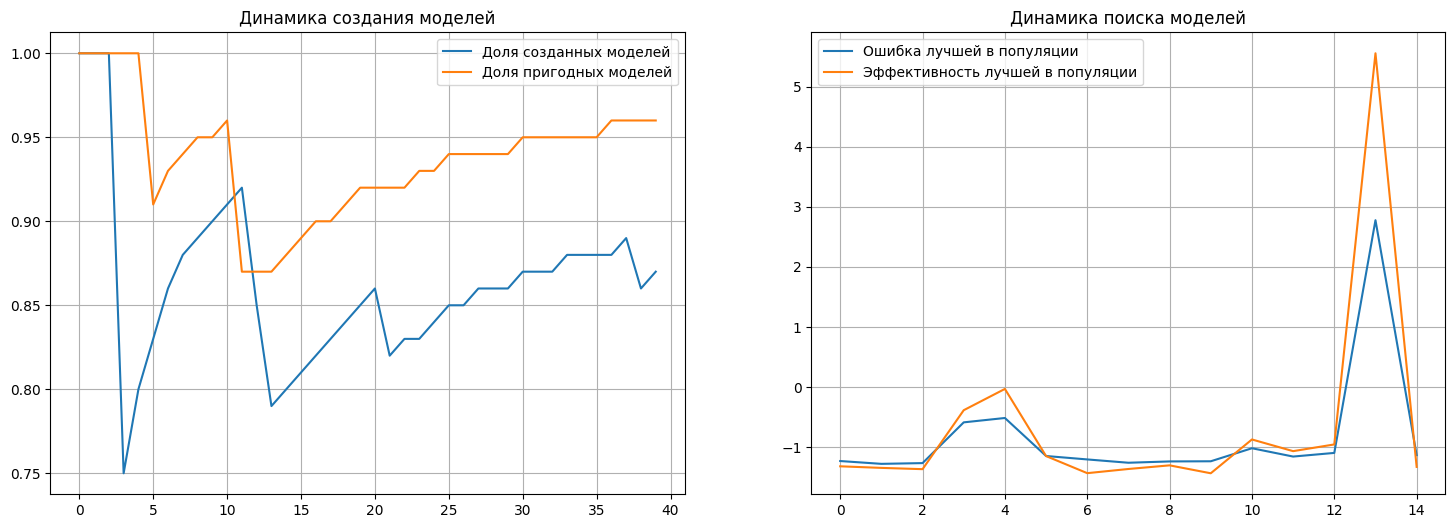


Мегапопуляция 7, эпоха 5
Модели популяции: создано [243, 0.87] брак [37, 0.13]
Модели популяции: пригодны [233, 0.96] не пригодны [47, 0.19]



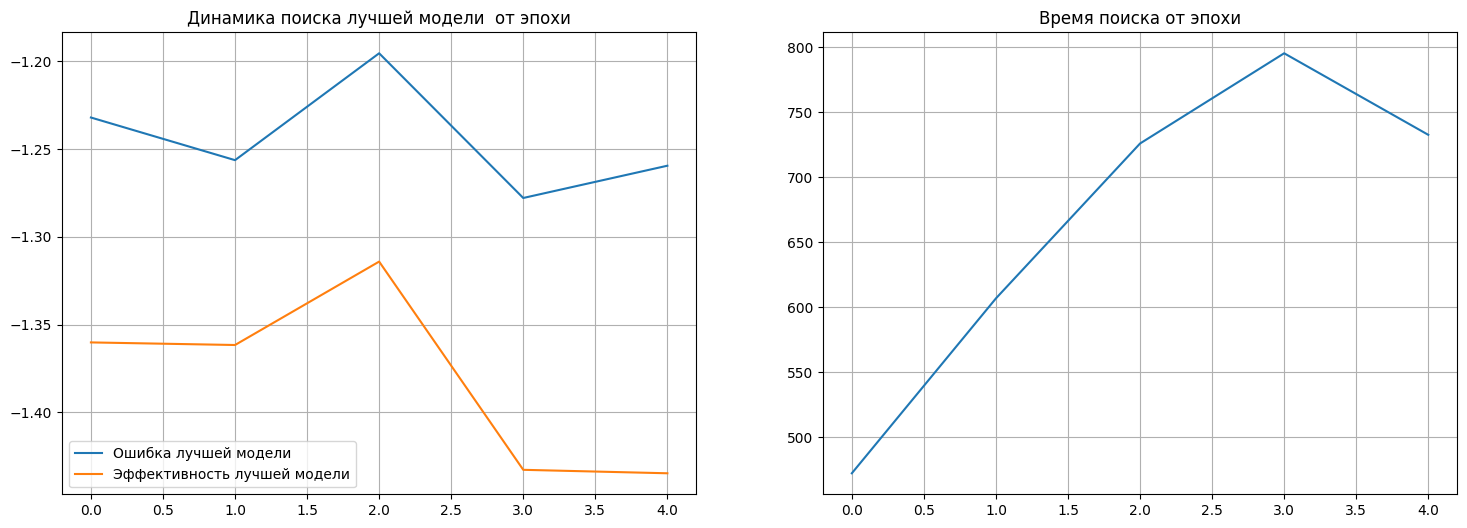


Эпоха 4, точность моделей [[0.05502847 0.06711512 0.06921561 0.07250953]
 [0.05788112 0.06471326 0.0727964  0.0807416 ]
 [0.05822686 0.06399545 0.06801273 0.07004949]
 [0.06976168 0.10774659 0.15603806 0.16376261]]
Время на эпоху 732.6295874118805, эффективность моделей [[0.03675475 0.04003287 0.04205225 0.04656587]
 [0.04332267 0.05121224 0.05603581 0.05744979]
 [0.04692921 0.04816071 0.11326489 0.11766676]
 [0.04979052 0.05785216 0.06379951 0.07003195]]
До окончания поиска 0 сек.
К-ко ошибок в длине ботов 0

Мегапопуляция 0 добавляем 5 ботов
Популяция 0, ботов 2
Популяция 0, дополнена до ботов 3
Популяция 0, дополнена до ботов 4
Популяция 0, дополнена до ботов 5
Популяция 0, дополнена до ботов 6
Популяция 0, дополнена до ботов 7
Популяция 0, ботов 7
Мегапопуляция 1 добавляем 5 ботов
Популяция 1, ботов 2
Популяция 1, дополнена до ботов 3
Популяция 1, дополнена до ботов 4
Популяция 1, дополнена до ботов 5
Популяция 1, дополнена до ботов 6
Популяция 1, дополнена до ботов 7
Популяция 1,

In [ ]:
selection(
        directory = directory,          # сколько выводим лучших для для изучения и посева
        waitnets = waitnets,            # сколько ожидаем лучших сетей
        dw = dw,                        # доля лучших с прошлых эпох для подсева
        frbest = frbest,                # как часто подсевыем лучших с прошлых эпох
        inshape = INSHAPE,              # размер входных данных
        predit_lag = PREDICT_LAG,       # размер предсказываемых данных
        type_data = "generator",        # метка, что тренируем на генераторе данных
        train_data = train_datagen,     # генератор данных для обучения
        val_data= val_datagen,          # генератор данных для валидации
        activ_lays = activ_lays,        # спиисок активационных функций из keras для внутреннмх слоев
        neiro_out = neiro_out,          # нейронов в выходнос слое, соответствует PREDICT_LAG
        activ_out = activ_out,          # спиисок активационных функций из keras для выходного слоя
        style_net = style_net,          # среди каких сетей ищем
        q_tyblocks = q_tyblocks,        # макс количество генерируемых блоков для сети
        q_lays = q_lays,                # макс количество слоев в блоках
        verbouse = verbouse,            # отображать ли тестовое обучение внутри генетики
        epohs = epohs,                  # Количество эпох для генетического поиска моделей
        test_eph = test_eph,            # Количество эпох тестового обучения моделей
        optimizer = optimizer,          # оптимизатор
        loss = loss,                    # функция потерь
        n = n,                          # количество ботов популяции
        p = p,                          # количество популяций
        dn = dn,                        # доля выживших ботов
        dp = dp,                        # доля выживших популяций
        dneff = dneff,                  # доля выживших ботов по эффективности
        dpeff = dpeff,                  # доля выживших популяций по эффективности
        prb_randbot = prb_randbot,      # вероятность появления случайного бота в новой популяции
        mutp = mutp,                    # Коэфициент мутаций при создании мегабота новой популяции
        mutn = mutn,                    # Коэфициент мутаций при создании бота новой сети в популяции
        dpsurv = dpsurv,                # доля от выживших ботов популяции используемыех в родителях
        dnsurv = dnsurv,                # доля от выживших ботов мегапопуляции используемыех в родителях
        posev = posev,                  # список ранее найденых генетикой сетей для продолжения поиска
        # нужно если check_aotocorr = True
        x_val = XVAL,                   # x валидационныые данные
        y_val = YVAL,                   # y валидационныые данные
        make_log = MAKE_LOG_TARGET,     # применяолсь логорифмирование для y
        y_scaler = Y_SCAILER,           # обученный скейлер для y для теста в лоссе
        check_aotocorr = True           # используем ли лосс автокорреляции в ошибке общей при отборе сетей генетикой

)